<h1 style="font-family:Times New Roman; font-size: 300%"><center>Machine Learning For Physics;Project 3 </center></h1>
<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Damped Pendulum Analysis</h2>

<p style="font-family:Times New Roman; font-size:120%">
    To say something more about the performance of each model, we try them on a more un-advantageous dataset, a damped pendulum. The HNN's are naturally less suitable for such problems, especially as the damping increases.
</p>

In [1]:
using Pkg; Pkg.activate("~/.julia/environments/v1.11.1")
Pkg.add("Revise"); using Revise
using Lux, Optimisers, Plots, Statistics, Random, LinearAlgebra, Zygote,Distributions,NBInclude
Pkg.add("MLUtils"); using MLUtils

includet("Data.jl")
includet("NeuralNetwork.jl")
using Base.Threads

  Activating project at `~/~/.julia/environments/v1.11.1`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`
┌ Warning: skipping callee Main.:(var"#RK4_step#6") (called by Main.RK4_step) due to AssertionError("isexpr(bodystmt, :call)")
└ @ LoweredCodeUtils ~/.julia/packages/LoweredCodeUtils/h7PQC/src/signatures.jl:328


In [2]:
function damped_pend_grads(y) #ODE for pendulum
    b=.1
    q = y[1,:]
    p = y[2,:]
    dq_dt=p
    dp_dt = @. -3*sin(q)-b*p
    return permutedims(hcat(dq_dt, dp_dt))
end

damped_pend_grads (generic function with 1 method)

In [3]:
rng = Random.MersenneTwister(42)

fieldd = meshgrid(20, train=false,range=2)
spring_field = grads_ideal_pend(fieldd).*0.1

t, x_train,y_train = generate_data(damped_pend_grads, 25, 30, 4*pi, sigma=0.01, sampler=sample_pend, min_e=0.01, max_e=5) |>f32
_, x_test, y_test = generate_data(damped_pend_grads, 1, 30, 4*pi, sigma=0.01, sampler=sample_pend, min_e=0.01, max_e=5) |>f32

x_Train = reshape(x_train, 2, 30*25)
y_Train = reshape(y_train, 2, 30*25)

train_data = DataLoader((x_Train,y_Train),batchsize=30)

25-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, batchsize=30)
  with first element:
  (2×30 Matrix{Float32}, 2×30 Matrix{Float32},)

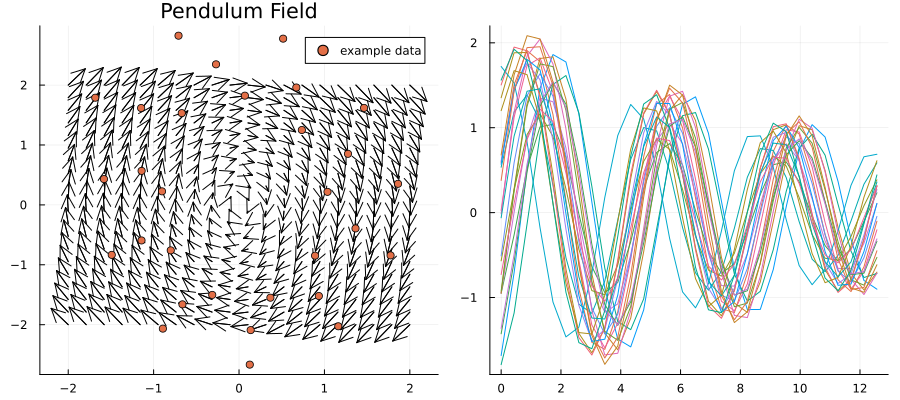

In [4]:
quiver(fieldd[1, :],fieldd[2, :],quiver=(spring_field[1, :], spring_field[2, :]), layout=(1,2),size=(900,400), title="Pendulum Field", label="train data",c=:black)
for i in 1:length(x_train[1,1,:])
    plot!(t, x_train[1,:,i], subplot=2,legend=false)
end
scatter!(x_train[1,:,1], x_train[2,:,1], label="example data",subplot=1)

<h2 style="font-family:Times New Roman; font-size:200%">Conducting analysis</h2>

<p style="font-family:Times New Roman; font-size:120%">
    We will now train the HNN's on the damped pendulum with tanh, sigmoid, mish, swish and gelu, each with various gains=0.01,0.1,0.5,1,s^0.5,2 and 5. This is done for Kaiming, Glorot and Orthogonal weight initilization. The example presented here consists of 64 neurons, with one hidden layer. All models are trained with ADAM, learning rate of 0.001, 1200 epochs and random seed 2024. 
</p>

In [5]:
activations = [tanh, sigmoid, mish, swish, gelu]
gains = [.01, .1, .5, 1, 2^0.5, 2, 5]
activations_str = ["tanh", "sigmoid", "mish", "swish", "gelu"]
gs=[.01, .1, .5, 1, 2^0.5, 2, 5]

MSE_valsk = zeros(length(activations), length(gains))
MSE_valsg = zeros(length(activations), length(gains))
MSE_valso = zeros(length(activations), length(gains))


Threads.@threads for a_idx in 1:length(activations)#for (a_idx, act) in enumerate(activations)
    act=activations[a_idx]
    
    Threads.@threads for g_idx in 1:length(gains)
        g_val=gains[g_idx]
        
        println("Doing $(activations_str[a_idx]) | Gain $(g_val)")
        
        _, LuxH_k = models(2, 64, act, Kaiming(g_val),1)
        _, LuxH_g = models(2, 64, act, Glorot(g_val),1)
        _, LuxH_o = models(2, 64, act, Orthogonal(g_val),1)
        
        #println(" -----  Training Kaiming  ----- ")
        pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1200)
        lossk = lossHNN(LuxH_k, x_test,pHNN_k, sHNN_k ,y_test)
        MSE_valsk[a_idx,g_idx] = lossk
        
        #println(" -----  Training Glorot  ----- ")
        pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN, train_data, x_test, y_test;epochs=1200)
        lossg = lossHNN(LuxH_g, x_test,pHNN_g, sHNN_g ,y_test)
        MSE_valsg[a_idx,g_idx] = lossg
        
        #println(" -----  Training Orthogonal  ----- ")
        pHNN_o, sHNN_o = train_model(LuxH_o, lossHNN, train_data, x_test, y_test;epochs=1200)
        losso = lossHNN(LuxH_o, x_test, pHNN_o, sHNN_o ,y_test)
        MSE_valso[a_idx,g_idx] = losso
    end
end

Doing tanh | Gain 0.5
Doing sigmoid | Gain 0.5
Doing tanh | Gain 1.4142135623730951
Doing tanh | Gain 0.1
Doing swish | Gain 5.0
Doing swish | Gain 0.1
Doing swish | Gain 0.5
Doing sigmoid | Gain 1.0
Doing tanh | Gain 0.01
Doing sigmoid | Gain 5.0
Doing swish | Gain 1.4142135623730951
Doing mish | Gain 0.1
Epoch=200 :loss = 0.28469452
Doing gelu | Gain 0.01
Doing gelu | Gain 1.0
Doing tanh | Gain 1.0
Doing sigmoid | Gain 0.1
Doing swish | Gain 2.0
Epoch=200 :loss = 0.25470316
Epoch=200 :loss = 0.0816497
Epoch=200 :loss = 0.0015261398
Epoch=200 :loss = 0.15576135
Doing sigmoid | Gain 1.4142135623730951
Epoch=400 :loss = 0.3069161
Epoch=200 :loss = 0.208908
Epoch=200 :loss = 0.057079688
Epoch=400 :loss = 0.289149
Epoch=200 :loss = 0.02867449
Epoch=400 :loss = 0.19288726
Epoch=200 :loss = 0.17110929
Epoch=400 :loss = 0.072246306
Epoch=600 :loss = 0.366855
Doing swish | Gain 1.0
Epoch=400 :loss = 0.10498784
Epoch=600 :loss = 0.23952246
Epoch=400 :loss = 0.0022605634
Epoch=400 :loss = 0.003

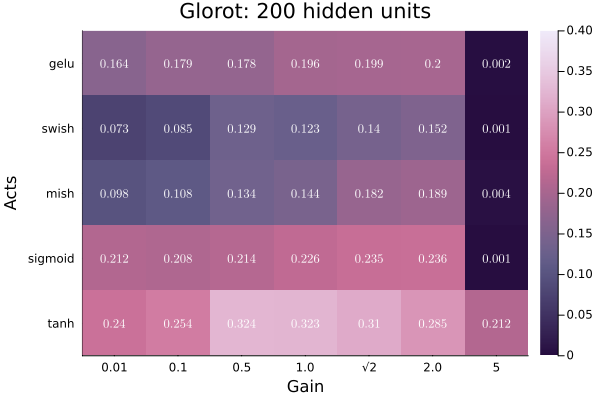

In [6]:
gain_str = ["0.01", "0.1", "0.5", "1.0", "√2", "2.0", "5"]
hg = heatmap(MSE_valsg, cmap=:acton,clim=(0, 0.4),title="Glorot: 200 hidden units", yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str), ylabel="Acts",xlabel="Gain")
annotate!(hg,[(j, i, text(round(MSE_valsg[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:length(activations) for j in 1:length(gains)])
hg

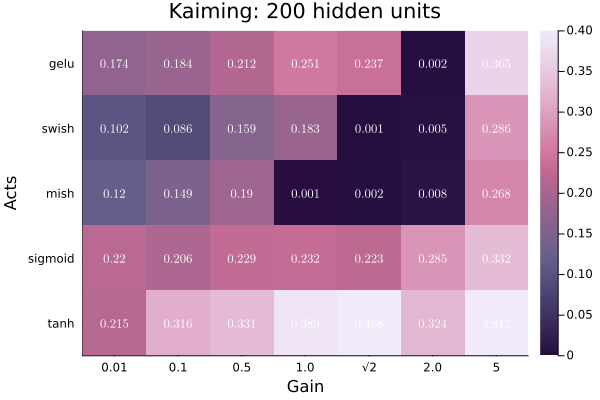

In [7]:
hk = heatmap(MSE_valsk, cmap=:acton, clim=(0,0.4),title="Kaiming: 200 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(hk,[(j, i, text(round(MSE_valsk[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
hk

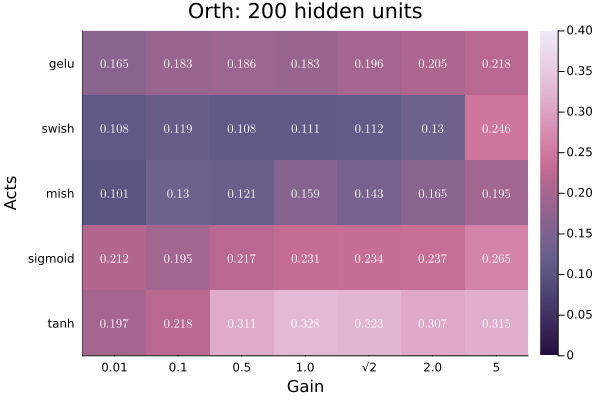

In [8]:
ho = heatmap(MSE_valso, cmap=:acton, clim=(0,0.4),title="Orth: 200 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(ho,[(j, i, text(round(MSE_valso[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
ho